In [50]:
from sklearn.model_selection import KFold
from data import load_camera, load_cmfs, load_dataset_sfu,load_insitu,  msds_to_rgb, msds_to_xyz, load_dataset_csv
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer, RGBtoXYZNetwork
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np
from colour import delta_E, XYZ_to_Lab

RANDOM_STATE = 42

SFU_FILE_PATH = 'data/reflect_db.reflect'  # SFU material reflectance database
INSITU_FILE_PATH = "data/insitu_dataset.csv"
CAVE_FOSTER_2002 = "data/cave_foster2002.csv"
CAMERA = 'sigma'


# Load the SFU dataset
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
insitu_dataset = load_insitu(INSITU_FILE_PATH)
cave_foster2002 = load_dataset_csv(CAVE_FOSTER_2002)
MSDS_TRAIN = load_camera(CAMERA)

cmfs, illuminant = load_cmfs()
y = msds_to_xyz(insitu_dataset, cmfs, illuminant)

X = msds_to_rgb(insitu_dataset,MSDS_TRAIN, illuminant)

In [51]:
# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Define models to evaluate
models = {
    "P-Spline-5, lam=1e-6": GAMOptimizer(lams=1e-6, order=3, n_splines=10),
    "P-Spline-5, lam=1e-5": GAMOptimizer(lams=1e-5, order=3, n_splines=10),
    "P-Spline-5, lam=1e-4": GAMOptimizer(lams=1e-4, order=3, n_splines=10),
    "P-Spline-5, lam=1e-3": GAMOptimizer(lams=1e-3, order=3, n_splines=10),
    "P-Spline-5, lam=1e-2": GAMOptimizer(lams=1e-2, order=3, n_splines=10),
    "P-Spline-5, lam=1e-1": GAMOptimizer(lams=1e-1, order=3, n_splines=10),
    "P-Spline-5, lam=3e-1": GAMOptimizer(lams=3e-1, order=3, n_splines=10),
    "P-Spline-5, lam=5e-1": GAMOptimizer(lams=5e-1, order=3, n_splines=10),
}

# Dictionary to hold the results
would_clip = np.any(X * 2 > 1, axis=1)  # Change '> 1' if not using normalized RGB values
# Exclude these samples from both X and y
X = X[~would_clip]
y = y[~would_clip]


In [44]:
import matplotlib.pyplot as plt
exposure_factors = [0.5, 1, 2]  # Simulate lower, same, and higher exposures
start_power = np.log10(5e-1)  # Equivalent to -0.30103
stop_power = np.log10(1e-9)   # Equivalent to -9

# Generate values using logspace
lams = np.logspace(start_power, stop_power, 20)
print(lams)
results = {str(lam): {str(factor): [] for factor in exposure_factors} for lam in lams}


for train_index, test_index in kf.split(X):
    X_train, X_test_original = X[train_index], X[test_index]
    y_train, y_test_original = y[train_index], y[test_index]
    for lam in lams:
        model = GAMOptimizer(lams=lam, n_splines=5, order=3)
        model.fit(X_train, y_train)
        for factor in exposure_factors:
            print(f"Evaluation model {n_splines} at exposure {factor} and lam {lam}")
            # Simulate change in exposure by scaling X_test
            X_test = X_test_original * factor   

            # Clip the scaled RGB values to [1, 1, 1]
            X_test = np.clip(X_test, 0, 1)

            # Correspondingly scale y_test for LCC invariance test and clip to [0.9504, 1.0000, 1.0888]
            y_test = y_test_original
            y_test = np.clip(y_test, [0, 0, 0], [0.9504, 1.0000, 1.0888])

            # Make predictions
            xyz = model.predict(X_test) / factor
            # xyz = np.clip(xyz, [0, 0, 0], [0.9504, 1.0000, 1.0888])

            # Evaluate the model (using an appropriate metric, e.g., RMSE)
            lab_pred = XYZ_to_Lab(xyz)
            lab_tre = XYZ_to_Lab(y_test)
            score = np.mean(delta_E(lab_pred, lab_tre, method="CIE 2000"))

            #  Append the score
            results[str(lam)][str(factor)].append(score)    

average_scores = {
    model_name: {factor: np.mean(scores) for factor, scores in factors.items()}
    for model_name, factors in results.items()
}


# Plotting
plt.figure(figsize=(10, 6))
for factor in exposure_factors:
    scores = [average_scores[str(lam)][str(factor)] for lam in lams]
    plt.plot(lams, scores, marker='o', label=f'Exposure {factor}')

plt.xlabel('λ')
plt.ylabel('Average Delta E 2000')
plt.title('Average Delta E 2000 by λ and Exposure Factor')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



[  5.00000000e-01   1.74232624e-01   6.07140147e-02   2.11567242e-02
   7.37238316e-03   2.56901933e-03   8.95213958e-04   3.11950954e-04
   1.08704067e-04   3.78795896e-05   1.31997206e-05   4.59964392e-06
   1.60281606e-06   5.58525697e-07   1.94626796e-07   6.78206747e-08
   2.36331483e-08   8.23533088e-09   2.86972662e-09   1.00000000e-09]
Evaluation model 20 at exposure 0.5 and lam 0.5
Evaluation model 20 at exposure 1 and lam 0.5
Evaluation model 20 at exposure 2 and lam 0.5
Evaluation model 20 at exposure 0.5 and lam 0.17423262420208926
Evaluation model 20 at exposure 1 and lam 0.17423262420208926
Evaluation model 20 at exposure 2 and lam 0.17423262420208926
Evaluation model 20 at exposure 0.5 and lam 0.0607140146726929
Evaluation model 20 at exposure 1 and lam 0.0607140146726929
Evaluation model 20 at exposure 2 and lam 0.0607140146726929
Evaluation model 20 at exposure 0.5 and lam 0.02115672420453486
Evaluation model 20 at exposure 1 and lam 0.02115672420453486
Evaluation mode

KeyboardInterrupt: 

Evaluation model 5 at exposure 0.5 and lam 0.5
Evaluation model 5 at exposure 1 and lam 0.5
Evaluation model 5 at exposure 2 and lam 0.5
Evaluation model 5 at exposure 0.5 and lam 0.17423262420208926
Evaluation model 5 at exposure 1 and lam 0.17423262420208926
Evaluation model 5 at exposure 2 and lam 0.17423262420208926
Evaluation model 5 at exposure 0.5 and lam 0.0607140146726929
Evaluation model 5 at exposure 1 and lam 0.0607140146726929
Evaluation model 5 at exposure 2 and lam 0.0607140146726929
Evaluation model 5 at exposure 0.5 and lam 0.02115672420453486
Evaluation model 5 at exposure 1 and lam 0.02115672420453486
Evaluation model 5 at exposure 2 and lam 0.02115672420453486
Evaluation model 5 at exposure 0.5 and lam 0.007372383155351938
Evaluation model 5 at exposure 1 and lam 0.007372383155351938
Evaluation model 5 at exposure 2 and lam 0.007372383155351938
Evaluation model 5 at exposure 0.5 and lam 0.0025690193275604944
Evaluation model 5 at exposure 1 and lam 0.002569019327560

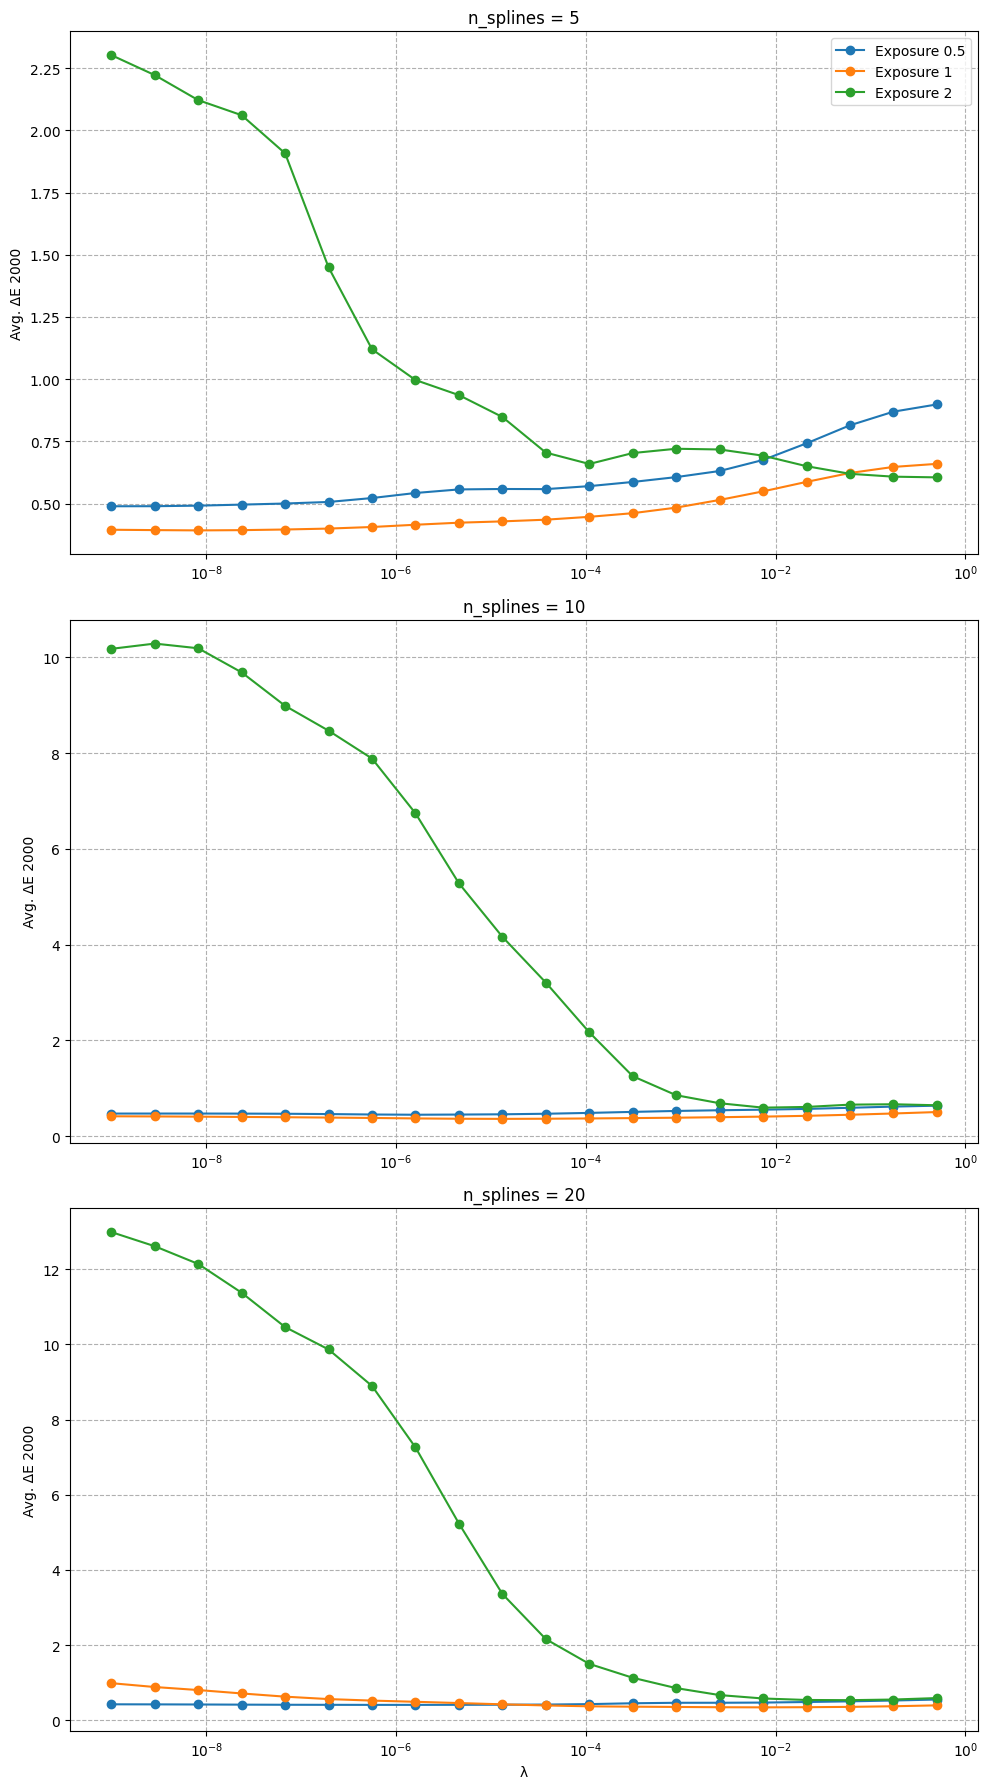

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Assuming GAMOptimizer, XYZ_to_Lab, delta_E, X, and y are defined as in your context

n_splines_options = [5, 10, 20]  # Different n_splines configurations
exposure_factors = [0.5, 1, 2]  # Exposure levels
lams = np.logspace(np.log10(5e-1), np.log10(1e-9), 20)  # Lambda values
kf = KFold(n_splits=5)  # KFold for your data splitting

def evaluate_model(X, y, kf, lams, exposure_factors, n_splines):
    results = {str(lam): {str(factor): [] for factor in exposure_factors} for lam in lams}

    for train_index, test_index in kf.split(X):
        X_train, X_test_original = X[train_index], X[test_index]
        y_train, y_test_original = y[train_index], y[test_index]
        
        for lam in lams:
            model = GAMOptimizer(lams=lam, n_splines=n_splines, order=3)
            model.fit(X_train, y_train)
            
            for factor in exposure_factors:
                print(f"Evaluation model {n_splines} at exposure {factor} and lam {lam}")
                X_test = np.clip(X_test_original * factor, 0, 1)
                y_test = np.clip(y_test_original, [0, 0, 0], [0.9504, 1.0000, 1.0888])

                xyz = model.predict(X_test) / factor
                lab_pred = XYZ_to_Lab(xyz)
                lab_true = XYZ_to_Lab(y_test)
                score = np.mean(delta_E(lab_pred, lab_true, method="CIE 2000"))

                results[str(lam)][str(factor)].append(score)

    return {
        model_name: {factor: np.mean(scores) for factor, scores in factors.items()}
        for model_name, factors in results.items()
    }

def plot_results(average_scores, n_splines, subplot_index, total_plots):
    plt.subplot(total_plots, 1, subplot_index)
    for factor in exposure_factors:
        scores = [average_scores[str(lam)][str(factor)] for lam in lams]
        plt.plot(lams, scores, marker='o', label=f'Exposure {factor}')

    plt.xlabel('λ' if subplot_index == total_plots else '')
    plt.ylabel('Avg. ΔE 2000')
    plt.title(f'n_splines = {n_splines}')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")

# Main plotting loop
plt.figure(figsize=(10, 6 * len(n_splines_options)))
for i, n_splines in enumerate(n_splines_options, start=1):
    average_scores = evaluate_model(X, y, kf, lams, exposure_factors, n_splines)
    plot_results(average_scores, n_splines, i, len(n_splines_options))

plt.tight_layout()
plt.show()


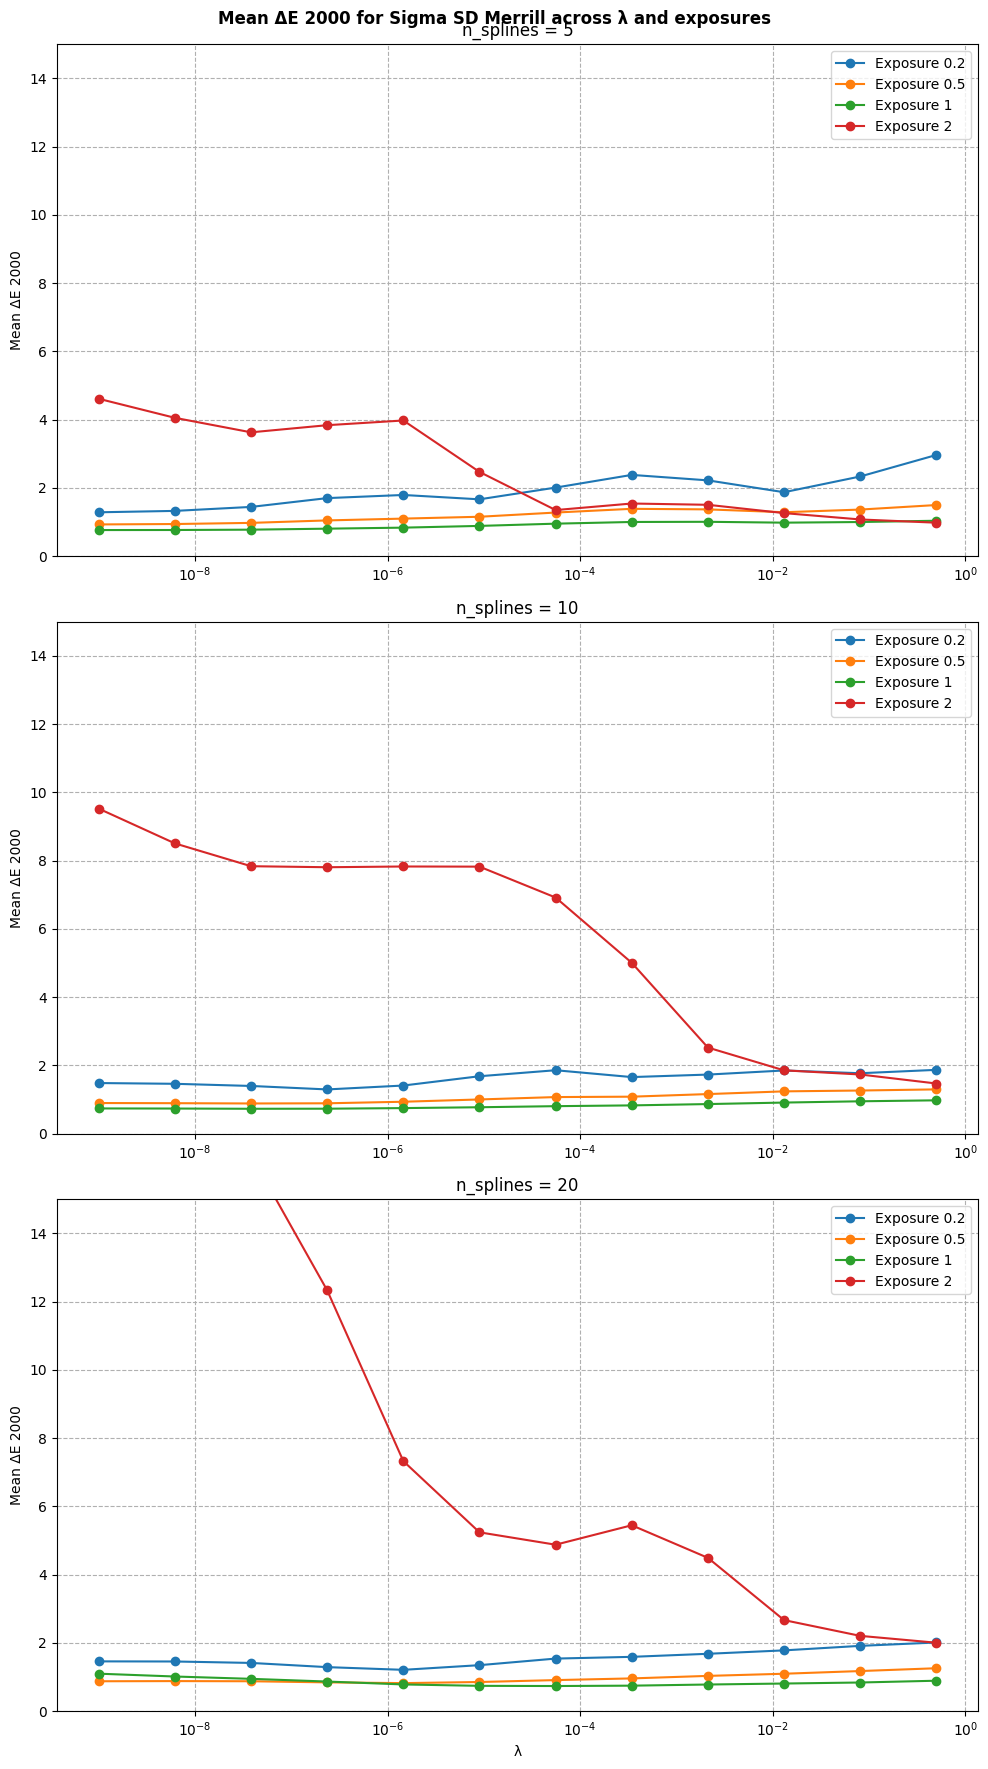

In [52]:
def evaluate_model(X, y, kf, lam, exposure_factor, n_splines):
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test_original = X[train_index], X[test_index]
        y_train, y_test_original = y[train_index], y[test_index]

        model = GAMOptimizer(lams=lam, n_splines=n_splines, order=3)
        model.fit(X_train, y_train)

        X_test = np.clip(X_test_original * exposure_factor, 0, 1)
        y_test = np.clip(y_test_original, [0, 0, 0], [0.9504, 1.0000, 1.0888])

        xyz = model.predict(X_test) / exposure_factor
        lab_pred = XYZ_to_Lab(xyz)
        lab_true = XYZ_to_Lab(y_test)
        score = np.mean(delta_E(lab_pred, lab_true, method="CIE 2000"))

        scores.append(score)

    return scores
def store_results(X, y, kf, lams, exposure_factors, n_splines_options):
    all_results = {}
    for n_splines in n_splines_options:
        n_splines_results = {}
        for lam in lams:
            lam_results = {}
            for factor in exposure_factors:
                scores = evaluate_model(X, y, kf, lam, factor, n_splines)
                lam_results[str(factor)] = np.mean(scores)  # Store average score
            n_splines_results[str(lam)] = lam_results
        all_results[str(n_splines)] = n_splines_results
    return all_results


def plot_results(all_results, exposure_factors):
    total_plots = len(all_results)
    plt.figure(figsize=(10, 6 * total_plots))

    for i, (n_splines, n_splines_results) in enumerate(all_results.items(), start=1):
        plt.subplot(total_plots, 1, i)
        for factor in exposure_factors:
            scores = [n_splines_results[str(lam)][str(factor)] for lam in lams]
            plt.plot(lams, scores, marker='o', label=f'Exposure {factor}')

        plt.xlabel('λ' if i == total_plots else '')
        plt.ylabel('Mean ΔE 2000')
        plt.title(f'n_splines = {n_splines}')
        plt.xscale('log')
        plt.ylim([0, 15])  # Set y-axis range from 0 to 10 for all plots
        plt.legend()
        plt.grid(True, which="both", ls="--")
    plt.suptitle("Mean ΔE 2000 for Sigma SD Merrill across λ and exposures", fontsize='large', fontweight="bold")

    plt.tight_layout()
    plt.show()

n_splines_options = [5, 10, 20]  # Different n_splines configurations
exposure_factors = [0.2, 0.5, 1, 2]  # Exposure levels
lams = np.logspace(np.log10(5e-1), np.log10(1e-9), 12)  # Lambda values
# Compute and store results
results = store_results(X, y, kf, lams, exposure_factors, n_splines_options)

# Plot the results
plot_results(results, exposure_factors)

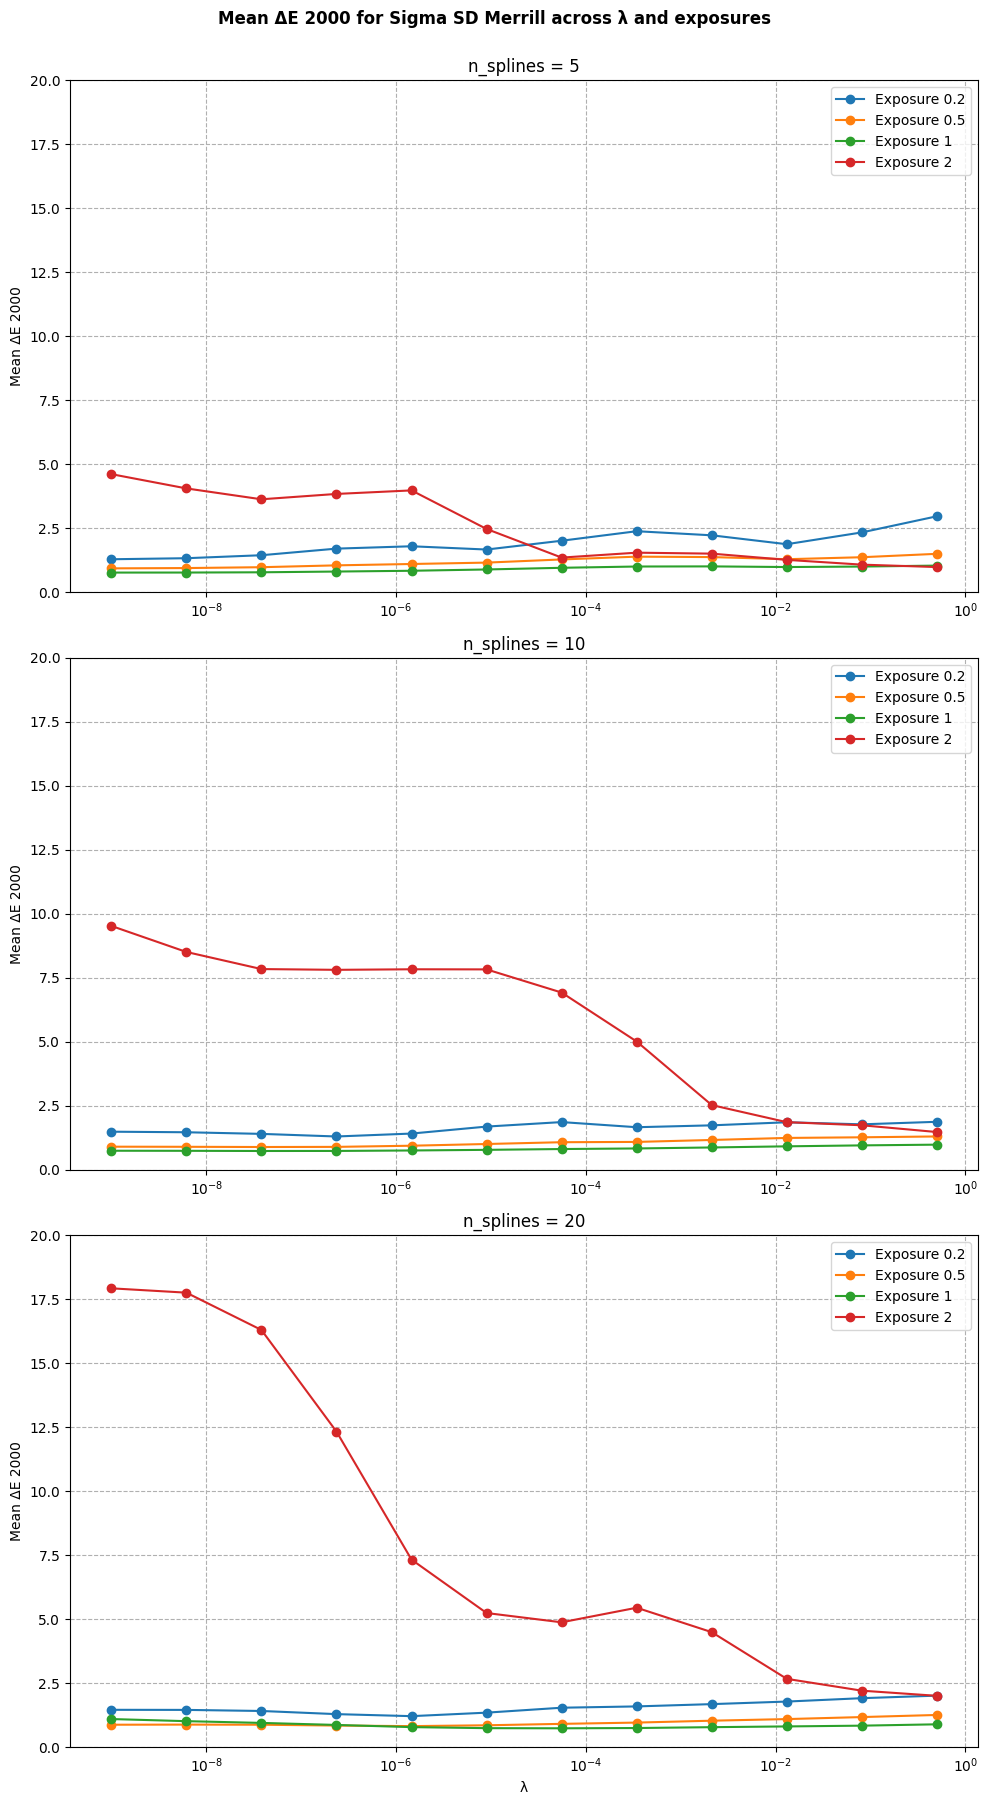

In [59]:
def plot_results(all_results, exposure_factors):
    total_plots = len(all_results)
    plt.figure(figsize=(10, 6 * total_plots))

    for i, (n_splines, n_splines_results) in enumerate(all_results.items(), start=1):
        plt.subplot(total_plots, 1, i)
        for factor in exposure_factors:
            scores = [n_splines_results[str(lam)][str(factor)] for lam in lams]
            plt.plot(lams, scores, marker='o', label=f'Exposure {factor}')

        plt.xlabel('λ' if i == total_plots else '')
        plt.ylabel('Mean ΔE 2000')
        plt.title(f'n_splines = {n_splines}')
        plt.xscale('log')
        plt.ylim([0, 20])  # Set y-axis range from 0 to 10 for all plots
        plt.legend()
        plt.grid(True, which="both", ls="--")
        plt.suptitle("Mean ΔE 2000 for Sigma SD Merrill across λ and exposures", fontsize='large', fontweight="bold", y=1)

    plt.tight_layout()
    plt.show()
# Plot the results
plot_results(results, exposure_factors)